## Промежуточный проект по курсу Машинное обучение (Нетология)

#### Задание
Мы владеем сетью магазинов, в которых продаются различные товары. Наши сотрудники собрали датасет из 8523 продаж товаров в различных магазинах нашей сети. Наша задача построить модель, предсказывающую продажи каждого продукта в конкретном магазине. Используя эту модель, попробовать выявить факторы, больше всего влияющие на увеличение продаж.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

import time

import warnings
warnings.filterwarnings('ignore')

Описание переменных в датасете

|  Name  | Description |
|---         |---       
| **Item_Identifier** |Id продукта |
| **Item_Weight** | Вес продукта |
| **Item_Fat_Content** | Содержание жира в продукте |
| **Item_Visibility** | %полок, отведенный под наш продукт в конкретном магазине |
| **Item_Type** | Категория продукта |
| **Item_MRP** | Максимальная цена продажи продукта |
| **Outlet_Identifier** | Идентификатор магазина |
| **Outlet_Establishment_Year** | Год открытия магазина |
| **Outlet_Size** | Площадь магазина |
| **Outlet_Location_Type** | Тип города, в котором расположен магазин |
| **Outlet_Type** | Признак является ли магазин продуктовым или супермаркетом |
| **Item_Outlet_Sales** | **Целевая переменная** Продажи продукта в конкретном магазине. |

In [2]:
df = pd.read_csv('data.csv')

### 1. Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


Первое, что бросается в глаза - у двух фичей (Item_Weight, Outlet_Size) не все данные

In [4]:
df.describe(include='all')

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,8523,7060.000000,8523,8523.000000,8523,8523.000000,8523,8523.000000,6113,8523,8523,8523.000000
unique,1559,NaN,5,NaN,16,NaN,10,NaN,3,3,4,NaN
top,FDG33,NaN,Low Fat,NaN,Fruits and Vegetables,NaN,OUT027,NaN,Medium,Tier 3,Supermarket Type1,NaN
freq,10,NaN,5089,NaN,1232,NaN,935,NaN,2793,3350,5577,NaN
mean,NaN,12.857645,NaN,0.066132,NaN,140.992782,NaN,1997.831867,NaN,NaN,NaN,2181.288914
std,NaN,4.643456,NaN,0.051598,NaN,62.275067,NaN,8.371760,NaN,NaN,NaN,1706.499616
min,NaN,4.555000,NaN,0.000000,NaN,31.290000,NaN,1985.000000,NaN,NaN,NaN,33.290000
25%,NaN,8.773750,NaN,0.026989,NaN,93.826500,NaN,1987.000000,NaN,NaN,NaN,834.247400
50%,NaN,12.600000,NaN,0.053931,NaN,143.012800,NaN,1999.000000,NaN,NaN,NaN,1794.331000
75%,NaN,16.850000,NaN,0.094585,NaN,185.643700,NaN,2004.000000,NaN,NaN,NaN,3101.296400


In [5]:
df.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


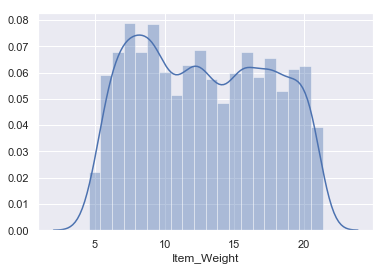

In [6]:
sns.distplot(df['Item_Weight'][~df['Item_Weight'].isna()])

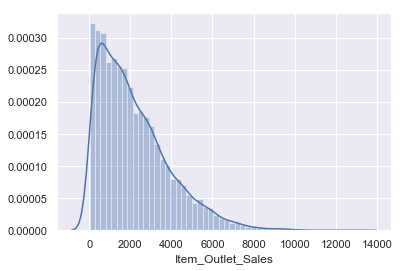

In [7]:
sns.distplot(df['Item_Outlet_Sales'])

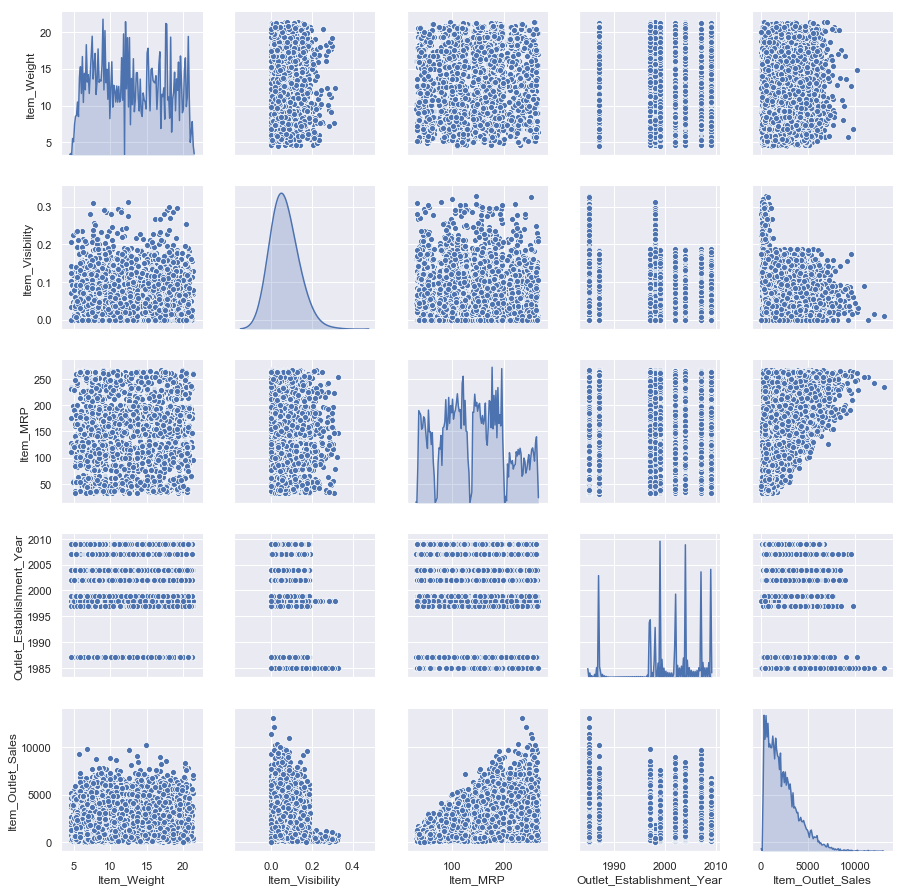

In [8]:
sns.pairplot(df, diag_kind="kde", diag_kws=dict(shade=True, bw=.05, vertical=False) )

Оценим, как тип магазина влияет на данные

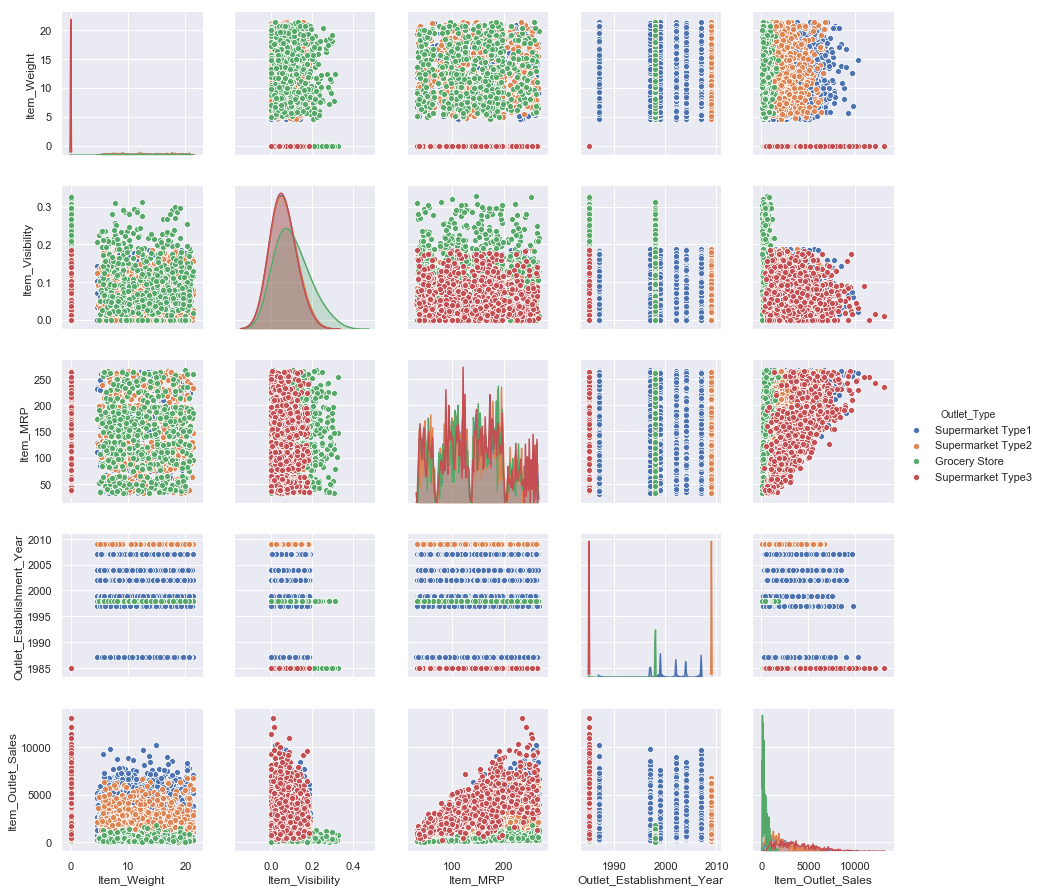

In [9]:
# необходимо для расчета pairplot
df['Item_Weight'] = df['Item_Weight'].fillna(0)

sns.pairplot(df, hue='Outlet_Type', diag_kind="kde", diag_kws=dict(shade=True, bw=.05, vertical=False) )

Довольно отчетливо видно, что тип магазина очень неплохо влияет на целевую переменную

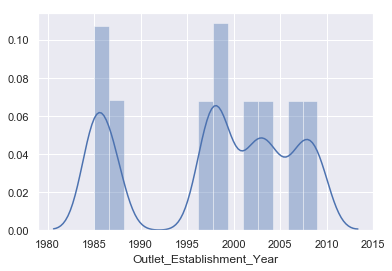

In [10]:
sns.distplot(df['Outlet_Establishment_Year'])

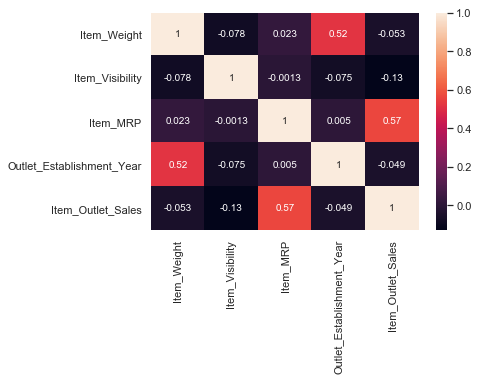

In [11]:
sns.heatmap(df.corr(), annot=True)

Наибольшая корреляция между продажами и максимальной ценой на товар (Item_MRP). 
Довольно очевидно.

### 2. Обработка категориальных переменных

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  8523 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


In [13]:
len(df['Item_Identifier'].unique())

1559

Довольно большое количество различных значений. Обработаем данную категориальную величину через LabelEncoding

In [14]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df['Item_Identifier'] = le.fit_transform(df['Item_Identifier'])

In [15]:
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

В данном случае стоит привести данные в один формат (LowFat и Regular) и использовать OneHotEncoding

In [16]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'Low Fat' : 'LowFat', 
                                                         'LF' : 'LowFat',
                                                         'low fat' : 'LowFat', 
                                                         'reg' : 'Regular'})
df['Item_Fat_Content'].value_counts()

LowFat     5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [17]:
# кандидат на get_dummies
df['Item_Type'].value_counts(normalize=False)

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [18]:
# кандидат на get_dummies
df['Outlet_Identifier'].value_counts(normalize=False)

OUT027    935
OUT013    932
OUT035    930
OUT049    930
OUT046    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

In [19]:
# можно попробовать восстановить данные по названию магазина
df['Outlet_Size'].value_counts(dropna=False, normalize=False)

Medium    2793
NaN       2410
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [20]:
# видим, что магазины 010, 013, 045 не имеют размера
df[['Outlet_Identifier', 'Outlet_Size', 'Item_Outlet_Sales']].groupby(['Outlet_Identifier']).count()
# можно рискнуть и попробовать догадаться по выручке товара выделить, какой магазин

,Outlet_Size,Item_Outlet_Sales
Outlet_Identifier,,
OUT010,0,555
OUT013,932,932
OUT017,0,926
OUT018,928,928
OUT019,528,528
OUT027,935,935
OUT035,930,930
OUT045,0,929
OUT046,930,930


In [21]:
df['Outlet_Size'] = df['Outlet_Size'].fillna('Unknown')
df['Outlet_Size'].value_counts(dropna=False, normalize=False)

Medium     2793
Unknown    2410
Small      2388
High        932
Name: Outlet_Size, dtype: int64

In [22]:
# кандидат на get_dummies
df['Outlet_Location_Type'].value_counts(dropna=False, normalize=False)

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [23]:
df['Outlet_Type'].value_counts(dropna=False, normalize=False)

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [24]:
categorical_features = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 
                        'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

In [25]:
def get_one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [26]:
df = get_one_hot(df=df, cols=categorical_features)

In [27]:
df.drop(labels=categorical_features, axis=1, inplace=True)

Уберем пропуски из названий признаков

In [28]:
df.columns = [x.replace(' ', '_') for x in df.columns]
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales',
       'Item_Fat_Content_LowFat', 'Item_Fat_Content_Regular',
       'Item_Type_Baking_Goods', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen_Foods',
       'Item_Type_Fruits_and_Vegetables', 'Item_Type_Hard_Drinks',
       'Item_Type_Health_and_Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack_Foods',
       'Item_Type_Soft_Drinks', 'Item_Type_Starchy_Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Size_High', 'Outlet_Size_Medium', 'Outlet_Size_Small

### 3. Устранение пропущенных значений


Изначально параметры Item_Weight и Outlet_Size имели пропуски.   
Outlet_Size был обработан с помощью OneHotEncoding заменой NaN на значение Unknown.  
Item_Weight будем обрабатывать с помощью Indicator Method - замена пропущенных значений нулями и создание новой переменной индикатора (где она принимает значение 1 при наличение пропуска и 0 в остальных случаях)

In [29]:
df['indicator_weight'] = df.Item_Weight.apply(lambda x : 1 if x == 0 else 0)
df.Item_Weight = df.Item_Weight.fillna(0)

In [30]:
print(sum(df.isna().sum()))

0


Пустые значения отсутствуют, двигаемся дальше

### 4. Изучение корреляции признаков с данными о продажах

Для этого воспользуемся пакетом statsmodels и посмотрим на p_value параметр, по которому примем решение, отклонять/не отклонять нулевую гипотезу (о том, что влияния параметра на целевую переменную нет). 

In [31]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [32]:
def get_formula(cols):
    return 'Item_Outlet_Sales ~ ' + " + ".join(cols)

In [33]:
cols = [x for x in df.columns if x not in 'Item_Outlet_Sales']

In [34]:
import scipy as sc

all_corr_col = []

# df 
for col in cols:
    if abs(sc.stats.pearsonr(df['Item_Outlet_Sales'], df[col])[0]) >=0.3:
        all_corr_col.append(col)
        
print(len(all_corr_col), all_corr_col, type(all_corr_col))

4 ['Item_MRP', 'Outlet_Identifier_OUT027', 'Outlet_Type_Grocery_Store', 'Outlet_Type_Supermarket_Type3'] <class 'list'>


Очень слабый результат. Посмотрим другой подход - воспользуемся пакетом statsmodels.api для расчета линейной регрессии и посчитаем p_value для всех значений

In [35]:
def check_correlation(cols):
    lm = smf.ols(get_formula(cols), df).fit()
    rss = np.sum(lm.resid ** 2)
    rmse = np.sqrt(rss / len(lm.resid))
    print("RMSE:", rmse)
    print("R^2:", lm.rsquared)
    lm_res = lm.summary()
    print(lm_res.tables[1])

In [36]:
check_correlation(cols)

RMSE: 1126.9813735849623
R^2: 0.5638136754044366
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           1.1980      0.220      5.445      0.000       0.767       1.629
Item_Identifier                     0.0434      0.045      0.973      0.331      -0.044       0.131
Item_Weight                        -0.5184      2.915     -0.178      0.859      -6.232       5.195
Item_Visibility                  -309.5975    248.773     -1.245      0.213    -797.252     178.057
Item_MRP                           15.5643      0.198     78.733      0.000      15.177      15.952
Outlet_Establishment_Year          -0.1568      0.029     -5.383      0.000      -0.214      -0.100
Item_Fat_Content_LowFat           -18.5861     14.161     -1.312      0.189     -46.345       9.173
Item_Fat_Content_Regular           19.7840     14.1

Получилось много переменных, у которых значения p_value > 0.05. Избавимся от большинства из них

In [37]:
cols = [x for x in df.columns if x not in 'Item_Outlet_Sales'
    and 'Item_Type' not in x
    and  'Item_Fat_Content' not in x
    and x not in ['Item_Identifier', 'Item_Weight', 'Item_Visibility', 
                 ] 
       ]
cols

['Item_MRP',
 'Outlet_Establishment_Year',
 'Outlet_Identifier_OUT010',
 'Outlet_Identifier_OUT013',
 'Outlet_Identifier_OUT017',
 'Outlet_Identifier_OUT018',
 'Outlet_Identifier_OUT019',
 'Outlet_Identifier_OUT027',
 'Outlet_Identifier_OUT035',
 'Outlet_Identifier_OUT045',
 'Outlet_Identifier_OUT046',
 'Outlet_Identifier_OUT049',
 'Outlet_Size_High',
 'Outlet_Size_Medium',
 'Outlet_Size_Small',
 'Outlet_Size_Unknown',
 'Outlet_Location_Type_Tier_1',
 'Outlet_Location_Type_Tier_2',
 'Outlet_Location_Type_Tier_3',
 'Outlet_Type_Grocery_Store',
 'Outlet_Type_Supermarket_Type1',
 'Outlet_Type_Supermarket_Type2',
 'Outlet_Type_Supermarket_Type3',
 'indicator_weight']

In [38]:
check_correlation(cols)

RMSE: 1127.762822501148
R^2: 0.5632085624649619
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.2080      0.184      6.558      0.000       0.847       1.569
Item_MRP                         15.5610      0.196     79.260      0.000      15.176      15.946
Outlet_Establishment_Year        -0.1629      0.015    -10.566      0.000      -0.193      -0.133
Outlet_Identifier_OUT010       -418.0292     19.820    -21.091      0.000    -456.882    -379.177
Outlet_Identifier_OUT013        -14.1152     13.823     -1.021      0.307     -41.212      12.982
Outlet_Identifier_OUT017        161.8250     27.969      5.786      0.000     106.999     216.651
Outlet_Identifier_OUT018       -154.9790     14.704    -10.540      0.000    -183.803    -126.155
Outlet_Identifier_OUT019       -461.8390     18.205    -25.369      0.

Попробуем еще использовать случайный лес для выбора фичей для моделей.
Для этого предподготовим данные


In [39]:
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics

In [40]:
target_feature = 'Item_Outlet_Sales'

X = df.drop(labels=target_feature, axis=1)
y = df[[target_feature]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [41]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [42]:
clf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [43]:
skf = KFold(n_splits=10)
sfs_forward = SFS(clf, k_features=10, forward=True, floating=True, verbose=1,
                  scoring='r2', cv=skf, n_jobs=-1)
sfs_forward = sfs_forward.fit(X_train.values, y_train.values,custom_feature_names=X_train.columns)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   13.8s finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:   31.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:   31.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.7s finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:   36.0s fini

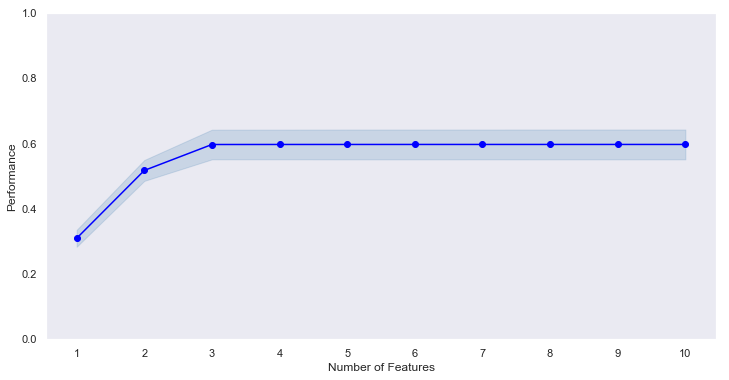

In [44]:
fig1 = plot_sfs(sfs_forward.get_metric_dict(), kind='std_dev')

plt.ylim([0, 1])
plt.grid()
fig1.set_size_inches(12, 6)
plt.show()

Интересно, что уже после добавления 4й фичи качество не особо сильно растет

In [45]:
sfs_forward.get_metric_dict()

{1: {'feature_idx': (3,),
  'cv_scores': array([0.33465795, 0.27395795, 0.32795469, 0.31810108, 0.29828591,
         0.34960589, 0.27885896, 0.27995822, 0.3362016 , 0.29833598]),
  'avg_score': 0.30959182236436034,
  'feature_names': ('Item_MRP',),
  'ci_bound': 0.01921613714175312,
  'std_dev': 0.025872898977736824,
  'std_err': 0.008624299659245608},
 2: {'feature_idx': (3, 40),
  'cv_scores': array([0.54610611, 0.4487001 , 0.51828073, 0.53680501, 0.53968373,
         0.54738389, 0.47522872, 0.50324891, 0.54765806, 0.51375012]),
  'avg_score': 0.5176845386720941,
  'feature_names': ('Item_MRP', 'Outlet_Type_Grocery_Store'),
  'ci_bound': 0.023747517146909758,
  'std_dev': 0.03197401785705693,
  'std_err': 0.01065800595235231},
 3: {'feature_idx': (3, 4, 40),
  'cv_scores': array([0.6129074 , 0.48940113, 0.56072078, 0.65212351, 0.62569862,
         0.64080238, 0.62053905, 0.59438656, 0.61079452, 0.56504489]),
  'avg_score': 0.5972418830931678,
  'feature_names': ('Item_MRP',
   'Outle

### 5. Выбор и обоснование метрики, на основе которой будет измеряться качество полученной модели

Задача регрессионная, поэтому в качестве метрики возьмем коэффициент детерминации, как одни из самых распространенных и надежных метрик для регрессионных задач. Параллельно будем смотреть на mse.

### 6. Построение и подбор оптимальных параметров для любой линейной модели

Посмотрим на модель обычной линейной регрессии и регрессий с регуляризацией (Rigde, Lasso и ElasticNet)

Для начала разобьем данные по новой с использованием только необходимых фичей

In [46]:
X = df[cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [47]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score

scaler = StandardScaler()
X_train_lin = scaler.fit_transform(X_train)
X_train_lin = pd.DataFrame(X_train_lin, columns=X.columns)

X_test_lin = scaler.transform(X_test)
X_test_lin = pd.DataFrame(X_test_lin, columns=X.columns)

In [48]:
clr_lr = LinearRegression()
lr_params = { 'fit_intercept' : [True, False]} 

In [49]:
clf_ridge = Ridge()
ridge_params = { 'alpha' : [0.001, 0.1, 1, 5 ] + [10 * x for x in range(10)] }

In [50]:
clf_lasso = Lasso()
lasso_params = { 'alpha' : [0.001, 0.1, 1, 5 ] + [10 * x for x in range(10)] }

In [51]:
clf_elastic_net = ElasticNet()
elastic_net_params = { 'alpha' : [0.001, 0.1, 1, 5 ] + [10 * x for x in range(10)] 
                     , 'l1_ratio' : [round(0.1 + 0.2 * x, 2) for x in range(4)]} 

In [52]:
def calculate_models(models, X_train, X_test, cv=10, scoring='r2'):
    "Функция для расчета моделей с помощью поиска по сетке и кросс-валидации"
    best_models = []
    for model in models:
        start = time.time()
        print('-----------------------------------------------------------')
        print('Model : {}'.format(model[0].__class__.__name__))
        print('Parameters : {}'.format(model[1]))
        gs = GridSearchCV( model[0], param_grid = model[1], cv=cv, scoring=scoring, n_jobs=-1)
        gs.fit(X_train, y_train)
        print('Best params      : {}'.format(gs.best_params_))
        y_pred_train = gs.predict(X_train)
        y_pred_test = gs.predict(X_test)
        best_train_score = r2_score(y_train, y_pred_train)
        print('Train score      : r2 : {}, MSE : {}'.format(
            best_train_score, mean_squared_error(y_train, y_pred_train)))
        print('Test score       : r2 : {}, MSE : {}'.format(
            r2_score(y_test, y_pred_test), mean_squared_error(y_test, y_pred_test)))
        print('Calculation time : {} sec'.format(time.time() - start))
        
        
        best_models.append( (gs.best_estimator_, best_train_score) )
    
    return best_models

In [53]:
models = [  (clr_lr, lr_params)
         , (clf_ridge, ridge_params)
         , (clf_lasso, lasso_params)
         , (clf_elastic_net, elastic_net_params)
         ]

best_linear_models = calculate_models(models=models, X_train=X_train_lin, 
                                      X_test=X_test_lin, cv=10, scoring='r2')

-----------------------------------------------------------
Model : LinearRegression
Parameters : {'fit_intercept': [True, False]}
Best params      : {'fit_intercept': True}
Train score      : r2 : 0.5657027519401794, MSE : 1283370.5933948997
Test score       : r2 : 0.5496695266170195, MSE : 1229557.261591244
Calculation time : 0.9998385906219482 sec
-----------------------------------------------------------
Model : Ridge
Parameters : {'alpha': [0.001, 0.1, 1, 5, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]}
Best params      : {'alpha': 30}
Train score      : r2 : 0.5657274669312955, MSE : 1283297.5593313496
Test score       : r2 : 0.5499202787323346, MSE : 1228872.6219710805
Calculation time : 0.4928421974182129 sec
-----------------------------------------------------------
Model : Lasso
Parameters : {'alpha': [0.001, 0.1, 1, 5, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]}
Best params      : {'alpha': 5}
Train score      : r2 : 0.5656647691841774, MSE : 1283482.8343826719
Test score       : r2

### 7. Построение и подбор оптимальных параметров для любой нелинейной модели

Посмотрим внимательнее на случайный лес, xgboost, knn и bagging

In [54]:
clf_rf = RandomForestRegressor()
rf_params = {'n_estimators': [ 100, 300 ]
            ,'max_depth': [ 3, 5, 10, 15 ]
            }

In [55]:
clf_xgb = XGBRegressor()
xgb_params = {'n_estimators': [ 100, 200,  300 ]
             ,'max_depth': [ 2, 3, 4, 5, 6 ] } 

In [56]:
models = [ (clf_rf, rf_params)
         , (clf_xgb, xgb_params)
         ]

best_nonlinear_models = calculate_models(models=models, X_train=X_train, 
                                         X_test=X_test, cv=10, scoring='r2')

-----------------------------------------------------------
Model : RandomForestRegressor
Parameters : {'n_estimators': [100, 300], 'max_depth': [3, 5, 10, 15]}
Best params      : {'max_depth': 5, 'n_estimators': 300}
Train score      : r2 : 0.6130181081496342, MSE : 1143551.294409024
Test score       : r2 : 0.5806835214979278, MSE : 1144878.3760379136
Calculation time : 37.824780225753784 sec
-----------------------------------------------------------
Model : XGBRegressor
Parameters : {'n_estimators': [100, 200, 300], 'max_depth': [2, 3, 4, 5, 6]}
Best params      : {'max_depth': 2, 'n_estimators': 100}
Train score      : r2 : 0.6180089800559208, MSE : 1128803.01251559
Test score       : r2 : 0.5811493547280364, MSE : 1143606.4909121576
Calculation time : 32.89687132835388 sec


### 8. Провести стекинг нескольких моделей

In [57]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[train_ind] = clf.predict(X_train.iloc[train_ind]).reshape(-1,1)
        meta_test += clf.predict(X_test).reshape(-1,1)
    
    return meta_train.flatten(), meta_test.flatten() / stack_cv.n_splits

In [58]:
best_nonlinear_models[:2]

[(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
             oob_score=False, random_state=None, verbose=0, warm_start=False),
  0.6130181081496342),
 (XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
         max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
         n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
         reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
         silent=True, subsample=1), 0.6180089800559208)]

Возьмем для стекинга 2 нелинейные модели и одну линейную

In [59]:
from sklearn.model_selection import StratifiedKFold, KFold

stack_cv = KFold(n_splits=3, random_state=42)

meta_train = []
meta_test = []
col_names = []

models = best_nonlinear_models[:2] + best_linear_models[:1]

for model_params in models:
    model = model_params[0]
    print('Calculating {} model ... '.format(model.__class__.__name__))
    meta_tr, meta_te = get_meta_features(model, X_train, y_train, X_test, stack_cv)
    meta_train.append(meta_tr)
    meta_test.append(meta_te)
    col_names.append(model.__class__.__name__)
print('Finished!')    

Calculating RandomForestRegressor model ... 
Calculating XGBRegressor model ... 
Calculating LinearRegression model ... 
Finished!


In [60]:
np.stack(meta_train, axis=1).shape

(6818, 3)

In [61]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

### 9. Оценить качество модели на отложенной выборке

In [62]:
from sklearn.model_selection import cross_val_score

In [63]:
final_clf = RandomForestRegressor(max_depth = 5, n_estimators = 100, random_state=100)
final_clf.fit(X_meta_train, y_train)

y_final_pred = final_clf.predict(X_meta_test)
round(r2_score(y_final_pred, y_test), 3)

0.388

Удивительно, но стекинг дал результат хуже, чем использование моделей по отдельности

### 10. Выбрать топ 3 признака больше всего влияющие на объемы продаж

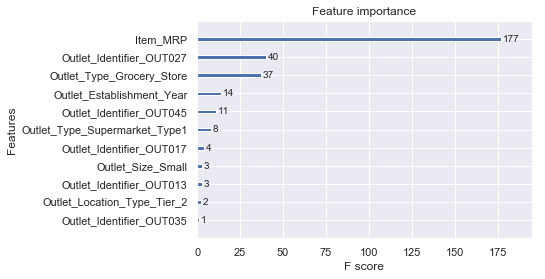

In [64]:
from xgboost import plot_importance
from matplotlib import pyplot

clf_xgboost = best_nonlinear_models[1][0]
plot_importance(clf_xgboost)
pyplot.show()

В качестве 3х топовых признаков - Item_MRP, Outlet_Identifiier_OUT027, Outlet_Type_Grocery_Store

Так же для отсройки важности воспользуемся библиотекой shap для нахождения и построения values.  
Библиотека shap позволяет немного по-другому считать важность параметров. 


In [65]:
# !pip install shap
import shap

In [66]:
shap.initjs()

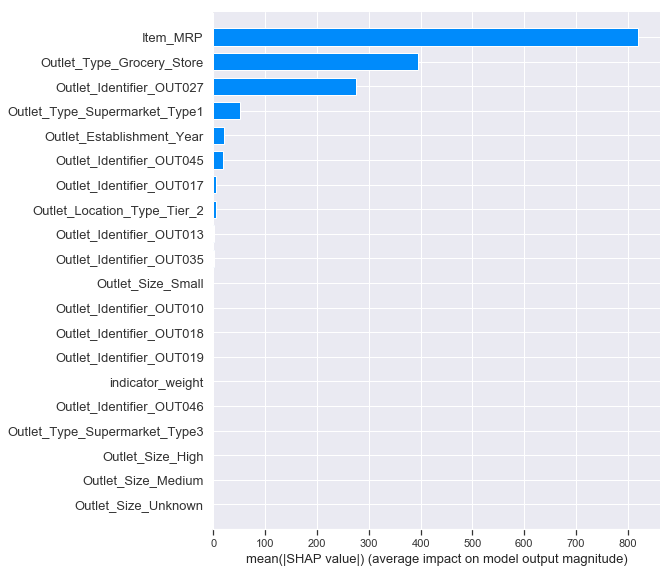

In [67]:
explainer = shap.TreeExplainer(clf_xgboost)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")

При использовании shap 3 топовых признаков - те же самые Item_MRP, Outlet_Identifiier_OUT027, Outlet_Type_Grocery_Store. 
Данные переменные довольно логично вышли в топ, что было частично предсказано на этапе EDA в самом начале работы.